In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
import pandas as pd

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/architmurgudkar/tensorflow-test/Projects/PotatoDiseaseClassification/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


2024-11-05 09:48:35.455472: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-05 09:48:35.455510: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-05 09:48:35.455519: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-05 09:48:35.455952: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-05 09:48:35.456213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

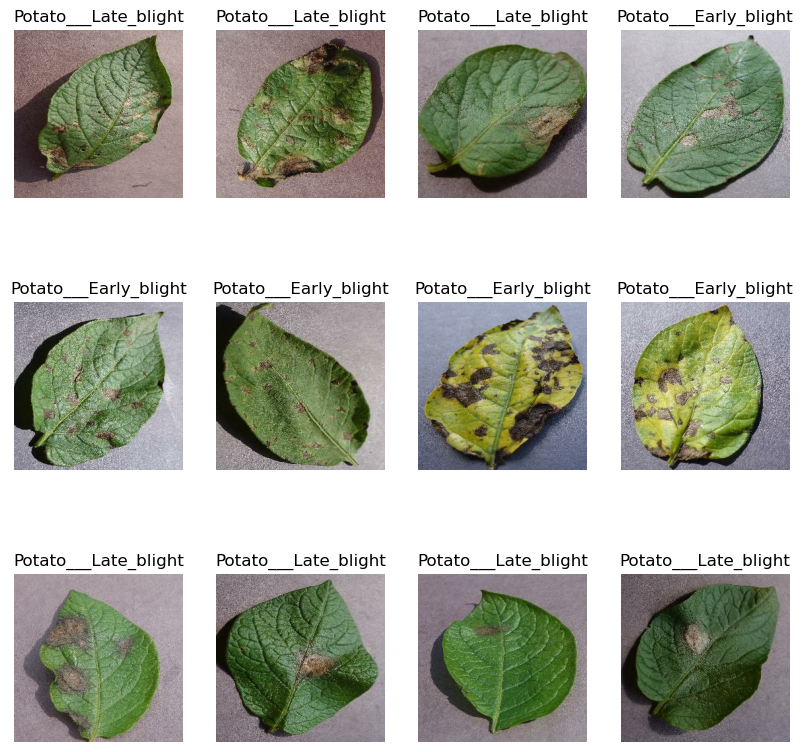

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])


In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds=dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset) 

In [18]:
print(f"Length of training data : {len(train_ds)}")
print(f"Length of training data : {len(val_ds)}")
print(f"Length of training data : {len(test_ds)}")

Length of training data : 54
Length of training data : 6
Length of training data : 8


In [19]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) 

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


2024-11-05 09:48:56.348445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-05 09:48:56.380702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-05 09:48:56.595451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 0.9202 - accuracy: 0.5052

2024-11-05 09:49:04.666596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 10s 120ms/step - loss: 0.9202 - accuracy: 0.5052 - val_loss: 0.8668 - val_accuracy: 0.7083
Epoch 2/50


2024-11-05 09:49:05.947832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 80ms/step - loss: 0.7050 - accuracy: 0.6985 - val_loss: 0.7444 - val_accuracy: 0.7448
Epoch 3/50
 1/54 [..............................] - ETA: 7s - loss: 0.8027 - accuracy: 0.6875

2024-11-05 09:49:10.426255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.5091 - accuracy: 0.7899 - val_loss: 0.3487 - val_accuracy: 0.8646
Epoch 4/50
 1/54 [..............................] - ETA: 7s - loss: 0.3309 - accuracy: 0.9062

2024-11-05 09:49:14.475064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.3804 - accuracy: 0.8519 - val_loss: 0.3044 - val_accuracy: 0.8802
Epoch 5/50
 1/54 [..............................] - ETA: 7s - loss: 0.2357 - accuracy: 0.9688

2024-11-05 09:49:18.550172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.2551 - accuracy: 0.9045 - val_loss: 0.2746 - val_accuracy: 0.9010
Epoch 6/50
 1/54 [..............................] - ETA: 7s - loss: 0.1334 - accuracy: 0.9688

2024-11-05 09:49:22.589258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.2906 - accuracy: 0.8785 - val_loss: 0.5036 - val_accuracy: 0.8333
Epoch 7/50
 1/54 [..............................] - ETA: 7s - loss: 0.0671 - accuracy: 0.9688

2024-11-05 09:49:26.631715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 75ms/step - loss: 0.2873 - accuracy: 0.8866 - val_loss: 0.5030 - val_accuracy: 0.7396
Epoch 8/50
 1/54 [..............................] - ETA: 7s - loss: 0.3576 - accuracy: 0.8750

2024-11-05 09:49:30.745809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.5471 - accuracy: 0.7743 - val_loss: 0.5249 - val_accuracy: 0.7604
Epoch 9/50
 1/54 [..............................] - ETA: 7s - loss: 0.4615 - accuracy: 0.7812

2024-11-05 09:49:34.792417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.2412 - accuracy: 0.8964 - val_loss: 0.2427 - val_accuracy: 0.9115
Epoch 10/50
 1/54 [..............................] - ETA: 7s - loss: 0.1579 - accuracy: 0.9688

2024-11-05 09:49:38.857997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.1798 - accuracy: 0.9311 - val_loss: 0.3741 - val_accuracy: 0.8385
Epoch 11/50
 1/54 [..............................] - ETA: 7s - loss: 0.2626 - accuracy: 0.8750

2024-11-05 09:49:42.933512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.1762 - accuracy: 0.9253 - val_loss: 0.1528 - val_accuracy: 0.9635
Epoch 12/50
 1/54 [..............................] - ETA: 7s - loss: 0.1100 - accuracy: 0.9688

2024-11-05 09:49:46.993536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 75ms/step - loss: 0.1798 - accuracy: 0.9346 - val_loss: 0.2304 - val_accuracy: 0.9271
Epoch 13/50
 1/54 [..............................] - ETA: 7s - loss: 0.1178 - accuracy: 0.9375

2024-11-05 09:49:51.140753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.1442 - accuracy: 0.9416 - val_loss: 0.1382 - val_accuracy: 0.9479
Epoch 14/50
 1/54 [..............................] - ETA: 7s - loss: 0.0179 - accuracy: 1.0000

2024-11-05 09:49:55.202694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.1070 - accuracy: 0.9606 - val_loss: 0.2374 - val_accuracy: 0.9062
Epoch 15/50
 1/54 [..............................] - ETA: 7s - loss: 0.1365 - accuracy: 0.9375

2024-11-05 09:49:59.259760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.1312 - accuracy: 0.9531 - val_loss: 0.2465 - val_accuracy: 0.9115
Epoch 16/50
 1/54 [..............................] - ETA: 7s - loss: 0.4087 - accuracy: 0.8750

2024-11-05 09:50:03.336513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.1494 - accuracy: 0.9468 - val_loss: 0.2004 - val_accuracy: 0.9323
Epoch 17/50
 1/54 [..............................] - ETA: 7s - loss: 0.0544 - accuracy: 0.9688

2024-11-05 09:50:07.400800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.1680 - accuracy: 0.9427 - val_loss: 0.1776 - val_accuracy: 0.9271
Epoch 18/50
 1/54 [..............................] - ETA: 7s - loss: 0.1074 - accuracy: 0.9688

2024-11-05 09:50:11.481018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.1050 - accuracy: 0.9647 - val_loss: 0.1637 - val_accuracy: 0.9479
Epoch 19/50
 1/54 [..............................] - ETA: 7s - loss: 0.0527 - accuracy: 0.9688

2024-11-05 09:50:15.570492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 75ms/step - loss: 0.1343 - accuracy: 0.9491 - val_loss: 0.3062 - val_accuracy: 0.9010
Epoch 20/50
 1/54 [..............................] - ETA: 7s - loss: 0.1405 - accuracy: 0.9688

2024-11-05 09:50:19.706961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.1840 - accuracy: 0.9282 - val_loss: 0.1179 - val_accuracy: 0.9583
Epoch 21/50
 1/54 [..............................] - ETA: 7s - loss: 0.0219 - accuracy: 1.0000

2024-11-05 09:50:23.754915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.1052 - accuracy: 0.9589 - val_loss: 0.1256 - val_accuracy: 0.9531
Epoch 22/50
 1/54 [..............................] - ETA: 7s - loss: 0.1136 - accuracy: 0.9375

2024-11-05 09:50:27.814780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.0790 - accuracy: 0.9688 - val_loss: 0.1676 - val_accuracy: 0.9323
Epoch 23/50
 1/54 [..............................] - ETA: 7s - loss: 0.0448 - accuracy: 0.9688

2024-11-05 09:50:31.915207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 77ms/step - loss: 0.0650 - accuracy: 0.9757 - val_loss: 0.3218 - val_accuracy: 0.8750
Epoch 24/50
 1/54 [..............................] - ETA: 7s - loss: 0.0992 - accuracy: 0.9688

2024-11-05 09:50:36.177873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.0851 - accuracy: 0.9676 - val_loss: 0.0498 - val_accuracy: 0.9792
Epoch 25/50
 1/54 [..............................] - ETA: 7s - loss: 0.0275 - accuracy: 1.0000

2024-11-05 09:50:40.230664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 75ms/step - loss: 0.0737 - accuracy: 0.9734 - val_loss: 0.2983 - val_accuracy: 0.8854
Epoch 26/50
 1/54 [..............................] - ETA: 7s - loss: 0.0172 - accuracy: 1.0000

2024-11-05 09:50:44.339480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.0991 - accuracy: 0.9653 - val_loss: 0.1296 - val_accuracy: 0.9635
Epoch 27/50
 1/54 [..............................] - ETA: 7s - loss: 0.1225 - accuracy: 0.9688

2024-11-05 09:50:48.398038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.0599 - accuracy: 0.9792 - val_loss: 0.0740 - val_accuracy: 0.9792
Epoch 28/50
 1/54 [..............................] - ETA: 7s - loss: 0.1025 - accuracy: 0.9375

2024-11-05 09:50:52.491320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.1023 - accuracy: 0.9653 - val_loss: 0.1906 - val_accuracy: 0.9531
Epoch 29/50
 1/54 [..............................] - ETA: 7s - loss: 0.0387 - accuracy: 1.0000

2024-11-05 09:50:56.576031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 75ms/step - loss: 0.0586 - accuracy: 0.9815 - val_loss: 0.1264 - val_accuracy: 0.9531
Epoch 30/50
 1/54 [..............................] - ETA: 7s - loss: 0.0172 - accuracy: 1.0000

2024-11-05 09:51:00.691571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.0471 - accuracy: 0.9832 - val_loss: 0.0869 - val_accuracy: 0.9792
Epoch 31/50
 1/54 [..............................] - ETA: 7s - loss: 0.0149 - accuracy: 1.0000

2024-11-05 09:51:04.800774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 75ms/step - loss: 0.0523 - accuracy: 0.9815 - val_loss: 0.1717 - val_accuracy: 0.9583
Epoch 32/50
 1/54 [..............................] - ETA: 7s - loss: 0.0015 - accuracy: 1.0000

2024-11-05 09:51:08.950032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.2483 - accuracy: 0.9120 - val_loss: 0.1873 - val_accuracy: 0.9323
Epoch 33/50
 1/54 [..............................] - ETA: 7s - loss: 0.1599 - accuracy: 0.9062

2024-11-05 09:51:13.003314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 75ms/step - loss: 0.0972 - accuracy: 0.9606 - val_loss: 0.2973 - val_accuracy: 0.8802
Epoch 34/50
 1/54 [..............................] - ETA: 7s - loss: 0.0486 - accuracy: 0.9688

2024-11-05 09:51:17.119794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.0630 - accuracy: 0.9751 - val_loss: 0.0653 - val_accuracy: 0.9792
Epoch 35/50
 1/54 [..............................] - ETA: 7s - loss: 0.0298 - accuracy: 1.0000

2024-11-05 09:51:21.226556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 75ms/step - loss: 0.0752 - accuracy: 0.9693 - val_loss: 0.2872 - val_accuracy: 0.8958
Epoch 36/50
 1/54 [..............................] - ETA: 7s - loss: 0.1295 - accuracy: 0.9688

2024-11-05 09:51:25.370417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 76ms/step - loss: 0.0629 - accuracy: 0.9769 - val_loss: 0.2304 - val_accuracy: 0.9062
Epoch 37/50
 1/54 [..............................] - ETA: 7s - loss: 0.2584 - accuracy: 0.9062

2024-11-05 09:51:29.544859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.0506 - accuracy: 0.9821 - val_loss: 0.0387 - val_accuracy: 0.9844
Epoch 38/50
 1/54 [..............................] - ETA: 7s - loss: 0.0939 - accuracy: 0.9688

2024-11-05 09:51:33.620987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.0805 - accuracy: 0.9699 - val_loss: 0.2072 - val_accuracy: 0.9375
Epoch 39/50
 1/54 [..............................] - ETA: 7s - loss: 0.0149 - accuracy: 1.0000

2024-11-05 09:51:37.675951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.0421 - accuracy: 0.9867 - val_loss: 0.1104 - val_accuracy: 0.9635
Epoch 40/50
 1/54 [..............................] - ETA: 7s - loss: 0.0094 - accuracy: 1.0000

2024-11-05 09:51:41.734025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.0505 - accuracy: 0.9815 - val_loss: 0.4053 - val_accuracy: 0.8802
Epoch 41/50
 1/54 [..............................] - ETA: 7s - loss: 0.1145 - accuracy: 0.9688

2024-11-05 09:51:45.773498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.0503 - accuracy: 0.9838 - val_loss: 0.0594 - val_accuracy: 0.9896
Epoch 42/50
 1/54 [..............................] - ETA: 7s - loss: 0.0250 - accuracy: 1.0000

2024-11-05 09:51:49.824071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.0640 - accuracy: 0.9740 - val_loss: 0.2503 - val_accuracy: 0.9271
Epoch 43/50
 1/54 [..............................] - ETA: 7s - loss: 0.1036 - accuracy: 0.9688

2024-11-05 09:51:53.877807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.0586 - accuracy: 0.9769 - val_loss: 0.1162 - val_accuracy: 0.9583
Epoch 44/50
 1/54 [..............................] - ETA: 7s - loss: 0.2278 - accuracy: 0.9062

2024-11-05 09:51:57.944830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 75ms/step - loss: 0.0922 - accuracy: 0.9682 - val_loss: 0.3267 - val_accuracy: 0.9010
Epoch 45/50
 1/54 [..............................] - ETA: 7s - loss: 0.1131 - accuracy: 0.9688

2024-11-05 09:52:02.063099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.0550 - accuracy: 0.9815 - val_loss: 0.0902 - val_accuracy: 0.9792
Epoch 46/50
 1/54 [..............................] - ETA: 7s - loss: 0.1048 - accuracy: 0.9375

2024-11-05 09:52:06.099128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 5s 88ms/step - loss: 0.0616 - accuracy: 0.9780 - val_loss: 0.0505 - val_accuracy: 0.9740
Epoch 47/50


2024-11-05 09:52:10.915047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 5s 87ms/step - loss: 0.0416 - accuracy: 0.9826 - val_loss: 0.1251 - val_accuracy: 0.9688
Epoch 48/50
 1/54 [..............................] - ETA: 7s - loss: 0.0030 - accuracy: 1.0000

2024-11-05 09:52:15.717712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 74ms/step - loss: 0.0528 - accuracy: 0.9809 - val_loss: 0.3448 - val_accuracy: 0.9323
Epoch 49/50
 1/54 [..............................] - ETA: 7s - loss: 0.0215 - accuracy: 1.0000

2024-11-05 09:52:19.788902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.0522 - accuracy: 0.9809 - val_loss: 0.0843 - val_accuracy: 0.9688
Epoch 50/50
 1/54 [..............................] - ETA: 7s - loss: 0.0462 - accuracy: 0.9688

2024-11-05 09:52:23.838847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 73ms/step - loss: 0.0532 - accuracy: 0.9832 - val_loss: 0.0942 - val_accuracy: 0.9635


In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 23ms/step - loss: 0.1413 - accuracy: 0.9531


In [28]:
scores

[0.14126618206501007, 0.953125]

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

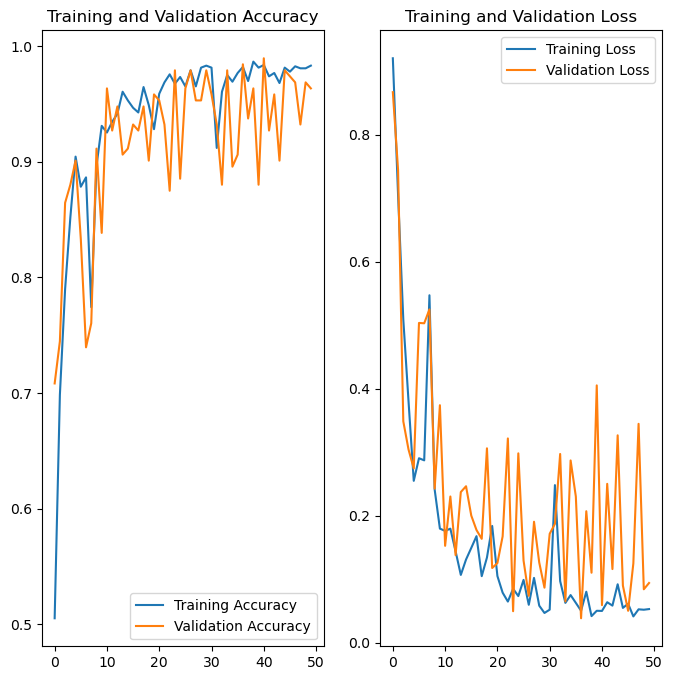

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
First image's actual label:  Potato___Early_blight
1/1 [==============================] - 0s 86ms/step
First image's predicted label: Potato___Early_blight


2024-11-05 09:52:29.024012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


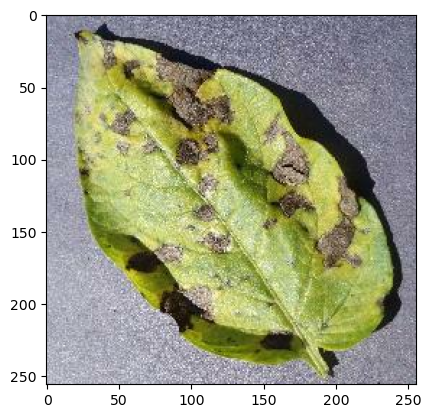

In [33]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]

    print("first image to predict")
    plt.imshow(first_image)
    print("First image's actual label: ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print(f"First image's predicted label: {class_names[np.argmax(batch_prediction[0])]}")
    


In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

2024-11-05 09:52:29.207199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 9ms/step


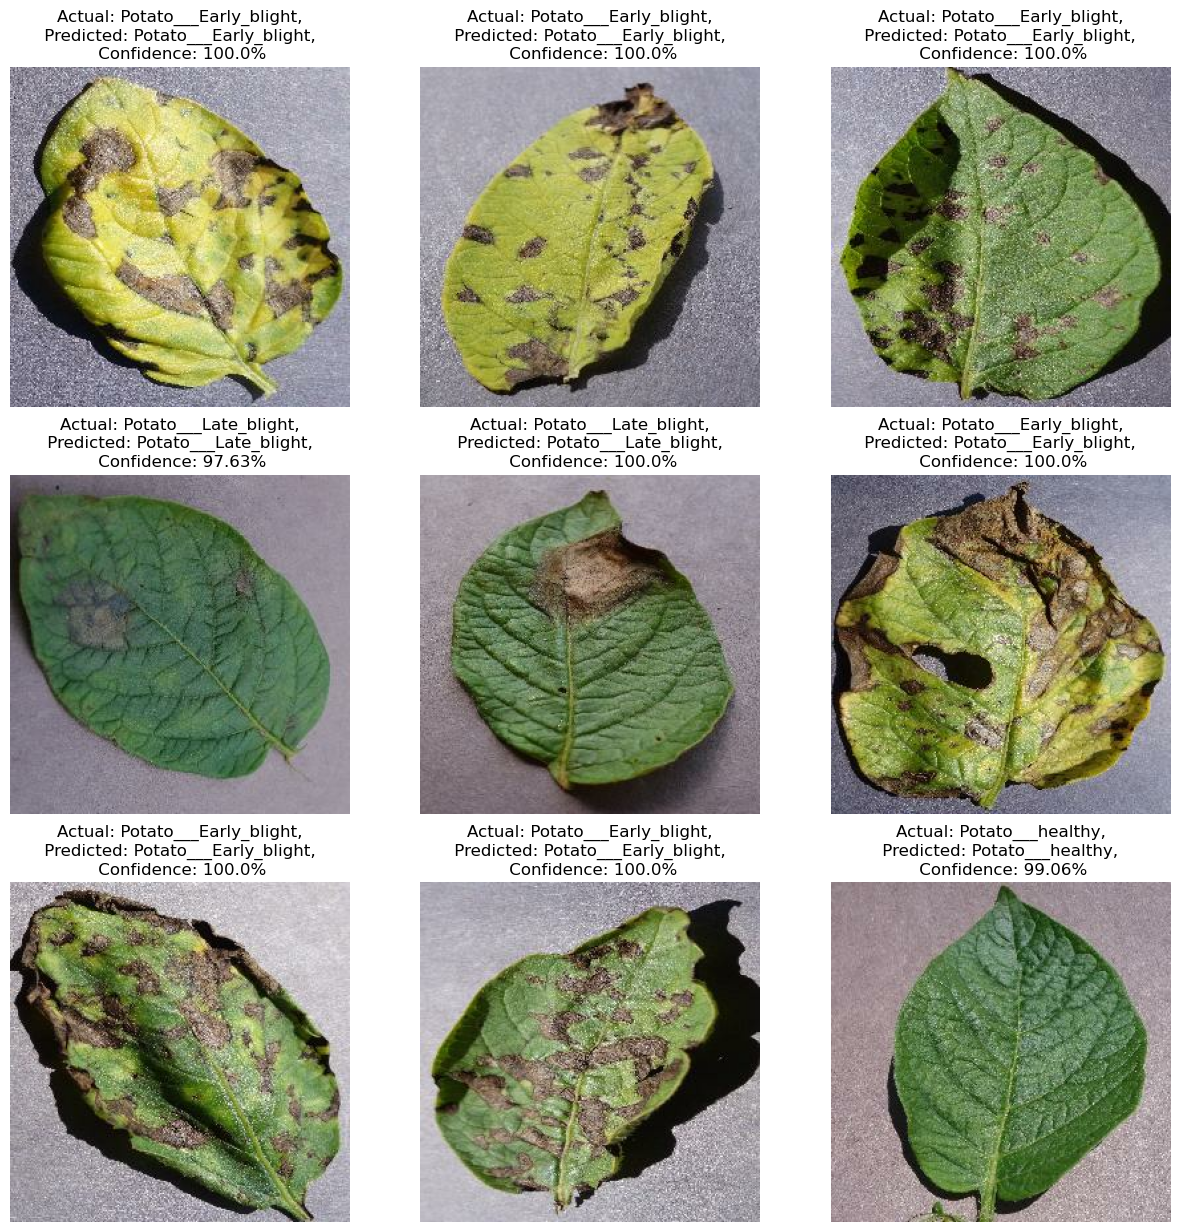

In [35]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range (9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")
    

In [38]:
model_version = 3
model.save(f"../Models/{model_version}")

INFO:tensorflow:Assets written to: ../Models/3/assets


INFO:tensorflow:Assets written to: ../Models/3/assets
